In [1]:
# # GOOGLE COLAB
import os
from google.colab import drive
drive.mount('/content/drive')
# change working directory if not done already
if os.getcwd().split('/')[-2] != 'My Drive':
 os.chdir('drive/MyDrive/laba')

Mounted at /content/drive


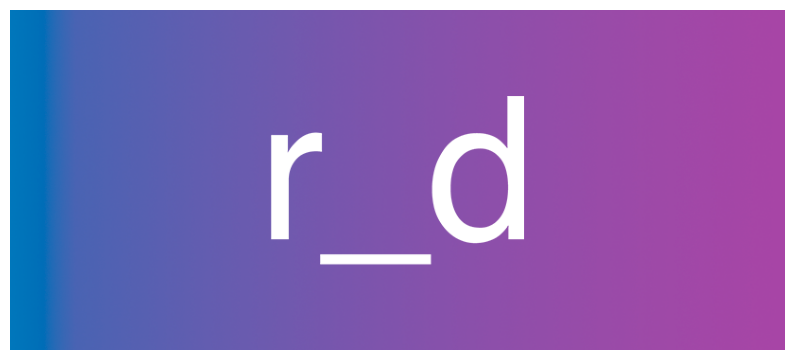

In [2]:
import rd_utils as rdu
rdu.show_logo()

<font size="10">Lekce 8 - domácí úloha</font>

- *"Tři nejdůležitější věci při prodeji a nákupu nemovitosti jsou lokalita, lokalita a lokalita"*  - neznámý autor

V následující úloze budete modelovat cenu pronájmu nemovitosti pomocí datasetu [Apartment for Rent Classified](https://archive.ics.uci.edu/dataset/555/apartment+for+rent+classified). Cílovou proměnnou je cena pronájmu. V úloze si vyzkoušíte následující:

- detekce odlehlých hodnot
- imputace chybějících hodnot
- transformace kategorických sloupců
- vytvoření polynomických členů (vyšší mocniny a interakce)
- lazení hyperparametrů

**Instrukce:**

 - vyplň všechna místa v kódu a odpovědi, kde je uvedeno "STUDENT"
 - nemaž předvyplněný kód v buňkách (např. `y_clf.head()` nebo  `y_pred[:5]`), aby bylo možné zkontrolovat Tvůj výsledek

# Housekeeping, načtení a zobrazení dat

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV

# Načtení dat

In [5]:
data_raw = pd.read_csv('datasets/apartment_for_rent/apartments_for_rent_classified_10K/apartments_for_rent_classified_10K.csv', sep=';', encoding='cp1252')

In [6]:
data_raw.head()

,id,category,title,body,amenities,bathrooms,bedrooms,currency,fee,has_photo,...,price_display,price_type,square_feet,address,cityname,state,latitude,longitude,source,time
0,5668626895,housing/rent/apartment,"Studio apartment 2nd St NE, Uhland Terrace NE,...","This unit is located at second St NE, Uhland T...",NaN,NaN,0.0,USD,No,Thumbnail,...,$790,Monthly,101,NaN,Washington,DC,38.9057,-76.9861,RentLingo,1577359415
1,5664597177,housing/rent/apartment,Studio apartment 814 Schutte Road,"This unit is located at 814 Schutte Road, Evan...",NaN,NaN,1.0,USD,No,Thumbnail,...,$425,Monthly,106,814 Schutte Rd,Evansville,IN,37.9680,-87.6621,RentLingo,1577017063
2,5668626833,housing/rent/apartment,"Studio apartment N Scott St, 14th St N, Arling...","This unit is located at N Scott St, 14th St N,...",NaN,1.0,0.0,USD,No,Thumbnail,...,"$1,390",Monthly,107,NaN,Arlington,VA,38.8910,-77.0816,RentLingo,1577359410
3,5659918074,housing/rent/apartment,Studio apartment 1717 12th Ave,"This unit is located at 1717 12th Ave, Seattle...",NaN,1.0,0.0,USD,No,Thumbnail,...,$925,Monthly,116,1717 12th Avenue,Seattle,WA,47.6160,-122.3275,RentLingo,1576667743
4,5668626759,housing/rent/apartment,"Studio apartment Washington Blvd, N Cleveland ...","This unit is located at Washington Blvd, N Cle...",NaN,NaN,0.0,USD,No,Thumbnail,...,$880,Monthly,125,NaN,Arlington,VA,38.8738,-77.1055,RentLingo,1577359401


In [7]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             10000 non-null  int64  
 1   category       10000 non-null  object 
 2   title          10000 non-null  object 
 3   body           10000 non-null  object 
 4   amenities      6451 non-null   object 
 5   bathrooms      9966 non-null   float64
 6   bedrooms       9993 non-null   float64
 7   currency       10000 non-null  object 
 8   fee            10000 non-null  object 
 9   has_photo      10000 non-null  object 
 10  pets_allowed   5837 non-null   object 
 11  price          10000 non-null  int64  
 12  price_display  10000 non-null  object 
 13  price_type     10000 non-null  object 
 14  square_feet    10000 non-null  int64  
 15  address        6673 non-null   object 
 16  cityname       9923 non-null   object 
 17  state          9923 non-null   object 
 18  latitud

## Popis datasetu

1. **id** (identifikátor): Unikátní identifikátor bytu.
2. **category** (kategorie): Kategorie inzerátu.
3. **title** (název): Text názvu bytu.
4. **body** (popis): Textový popis bytu.
5. **amenities** (vybavení): Vybavení bytu, jako např. klimatizace, basketbalový kruh, kabelová televize, fitness centrum, přístup k internetu, bazén, lednice apod.
6. **bathrooms** (koupelny): Počet koupelen.
7. **bedrooms** (ložnice): Počet ložnic.
8. **currency** (měna): Měna inzerátu.
9. **fee** (poplatek): Případný poplatek.
10. **has_photo** (obsahuje_foto): Udává, zda má inzerát fotografie bytu.
11. **pets_allowed** (povolení_domácích_mazlíčků): Která zvířata jsou povolena (např. psi, kočky atd.).
12. **price** (cena): Cenová nájemného bytu.
13. **price_display** (zobrazená_cena): Cena převedená do formátu vhodného pro čtenáře.
14. **price_type** (typ_ceny): Typ ceny v USD.
15. **square_feet** (čtvereční_stopy): Velikost bytu v čtverečních stopách.
16. **address** (adresa): Místo, kde se byt nachází.
17. **cityname** (název_města): Město, kde se byt nachází.
18. **state** (stát): Stát, kde se byt nachází.
19. **latitude** (zeměpisná_šířka): Zeměpisná šířka místa, kde se byt nachází.
20. **longitude** (zeměpisná délka): Zeměpisná délka místa, kde se byt nachází.
21. **source** (zdroj): Původ inzerátu.
22. **time** (čas): Kdy byl inzerát vytvořen.

## Zúžení datasetu na vybrané proměnné

Budeme pracovat pouze s vybranými proměnnými, protože ostatní proměnné vyžadují více práce s preprocessingem, což by značně zvýšilo náročnost úkolu.

In [8]:
data_narrow = data_raw[['price', 'bathrooms', 'bedrooms', 'square_feet', 'cityname', 'state', 'latitude', 'longitude']].copy()

# Analýza dat

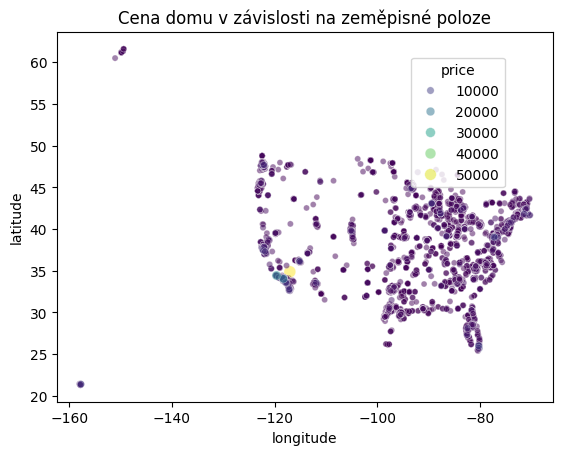

In [9]:
sns.scatterplot(
    data=data_raw,
    x="longitude",
    y="latitude",
    size="price",
    hue="price",
    palette="viridis",
    alpha=0.5,
)
plt.legend(title="price", bbox_to_anchor=(0.7, 0.95), loc="upper left")
plt.title("Cena domu v závislosti na zeměpisné poloze");

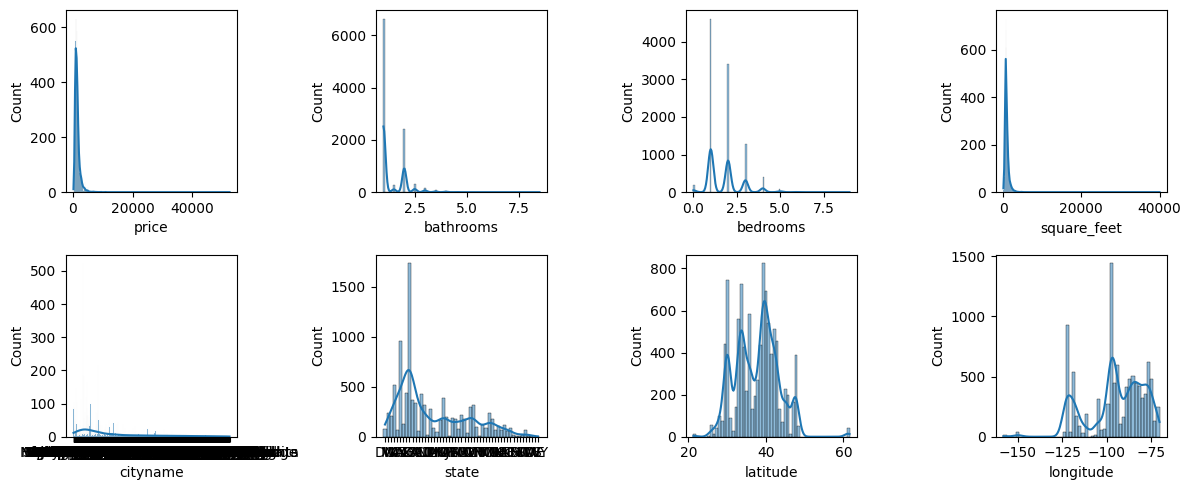

In [10]:
rdu.plot_histograms(data_narrow)

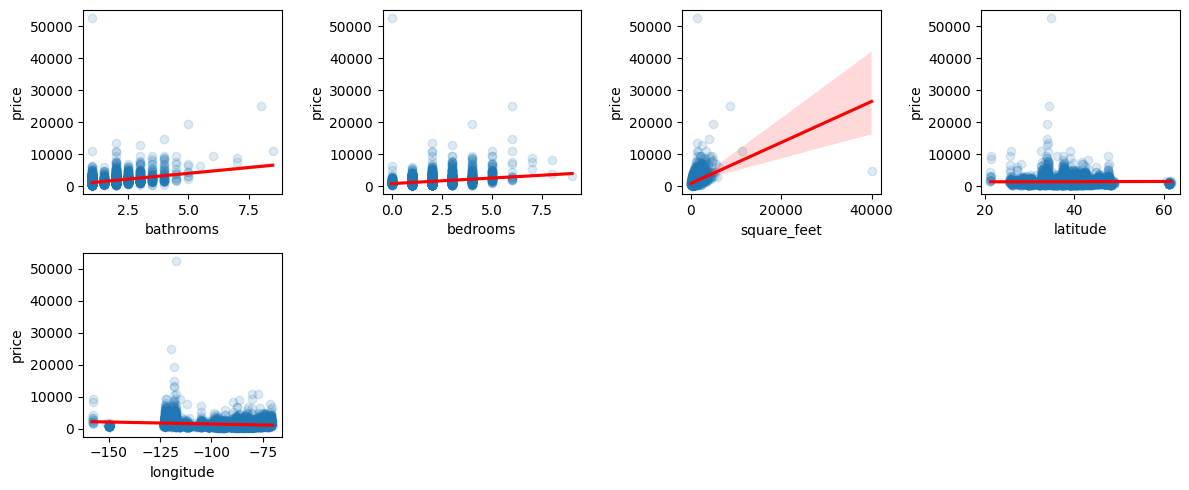

In [ ]:
rdu.plot_pairplots(data_narrow, y_var='price', drop_vars=['state', 'cityname'])

## Zjištění chybějících hodnot

**ÚKOL:** Libovolnou metodou zjistěte počet chybějících pozorování v každém sloupci. (Jejich imputaci budeme později řešit v rámci pipeline).

In [11]:
# počet chybějících hodnot v každém sloupci

# počty pozorování s hodnotou 0
(data_narrow==0).sum()

price            0
bathrooms        0
bedrooms       198
square_feet      0
cityname         0
state            0
latitude         0
longitude        0
dtype: int64

In [12]:
# počet chybějících hodnot
data_narrow.isna().sum()

price           0
bathrooms      34
bedrooms        7
square_feet     0
cityname       77
state          77
latitude       10
longitude      10
dtype: int64

# Detekce odlehlých pozorování a jejich odfiltrování z datasetu

V této části budete detekovat odlehlé hodnoty. Hodnoty budete detekovat ve 2D prostoru proměnných `price` a `square_feet`. Pro detekci použijete algoritmus `KNN` (viz lekce 7.3).

Doplňte kód všude, kde je uvedeno "STUDENT".

In [13]:
from sklearn.neighbors import NearestNeighbors

In [14]:
# vytvoření dílčího datasetu určeného pouze pro detekci odlehlých pozorování
data_nn = data_narrow[['price', 'square_feet']]

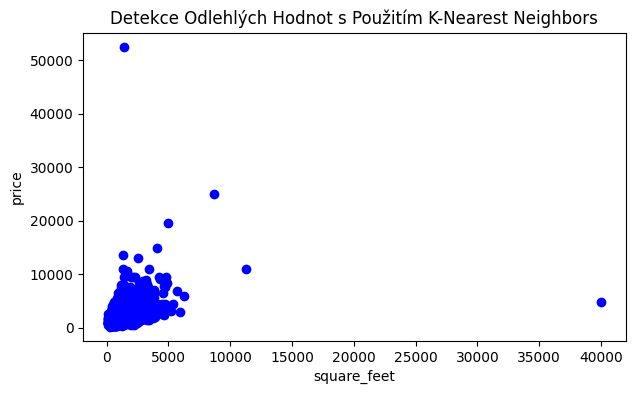

In [15]:
# Zobrazení výsledků
plt.figure(figsize=(7, 4))
plt.scatter(data_nn.square_feet, data_nn.price, color='blue')
plt.title('Detekce Odlehlých Hodnot s Použitím K-Nearest Neighbors')
plt.xlabel('square_feet')
plt.ylabel('price')
plt.show()

Na grafu výše si všiměte, která pozorování leží "stranou" od těch ostatních.

In [16]:
# Vytvořte a natrénujte (.fit) model NearestNeighbors. V dalších krocích jej použijeme ke zjištění vzdálenosti k sousením bodům.
knn = NearestNeighbors(n_neighbors= 5)# <-- STUDENT
knn.fit(data_nn)

NearestNeighbors()

In [17]:
# Výpočet vzdáleností k nejbližším sousedům
distances, _ = knn.kneighbors()

In [18]:
# Výpočet skóre odlehlých hodnot (zde použijeme průměrnou vzdálenost k N pozorování)
outlier_scores = np.mean(distances, axis=1)

In [19]:
# Definování prahu pro detekci odlehlých hodnot (např. 99.9 percentil)
threshold = np.percentile(outlier_scores, 99.9)
threshold

1451.3989087129478

In [20]:
# Vytvořte vektor obsahující čísla 1 (je odlehlé pozorování) a 0 (není odlehlé pozorování).
outlier_pred = (outlier_scores > threshold).astype(int) # <-- STUDENT

Následující buňka slouží k ověření, že vektor s predikcemi odlehlých pozorování má stejnou délku, jako je počet řádků v kompletním datasetu. Funkce `assert` vrací chybu v případě, že zmíněná podmínka neplatí.

In [21]:
assert(len(outlier_pred) == data_narrow.shape[0])

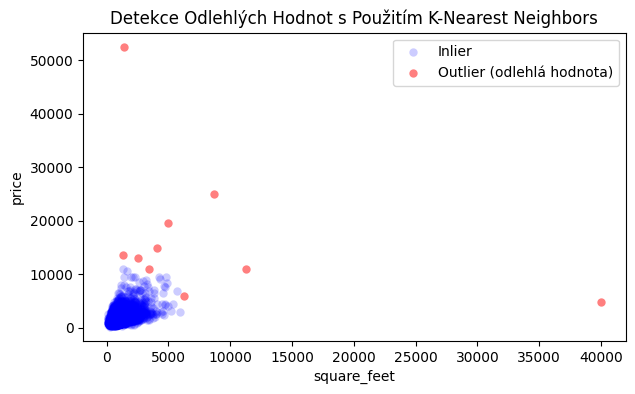

In [22]:
# Zobrazení výsledků
plt.figure(figsize=(7, 4))
plt.scatter(data_nn.loc[outlier_pred == 0, 'square_feet'], data_nn.loc[outlier_pred == 0, 'price'], color='blue', label='Inlier', alpha=0.2, linewidths=0)
plt.scatter(data_nn.loc[outlier_pred == 1, 'square_feet'], data_nn.loc[outlier_pred == 1, 'price'], color='red', label='Outlier (odlehlá hodnota)', alpha=0.5, linewidths=0)
plt.title('Detekce Odlehlých Hodnot s Použitím K-Nearest Neighbors')
plt.xlabel('square_feet')
plt.ylabel('price')
plt.legend()
plt.show()

Náseldující obrázek ukazuje, jak by měl vypadat předešlý graf.

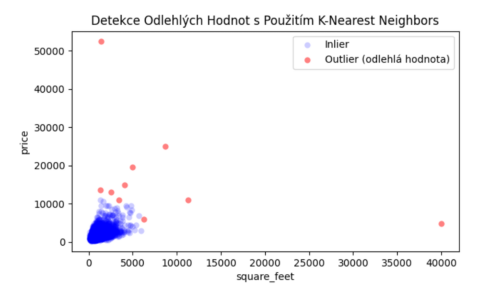

In [ ]:
rdu.show_image('./lessons/L08_crossvalidace_tuning/domaci_uloha/img/outlier_result.png', 6)

## Odfiltrování odlehlých hodnot z datasetu

In [23]:
data = data_narrow.loc[outlier_pred == 0, :]

Následující buňka slouží k ověření, že profiltrovaný dataset má správné rozměry. Funkce `assert` vrací chybu v případě, že uvedená podmínka neplatí.

In [24]:
assert(data.shape == (9990, 8))

# Rozdělení dat pro modelování

**ÚKOL:** Rozdělte dataset na X a y a následně na X_train, X_test, y_train, y_test. Velokost testovací množiny 25 % a náhodný stav (random state) 42.

In [46]:
X = data.drop(columns='price')  # <-- STUDENT
y = data['price']  # <-- STUDENT

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)  # <-- STUDENT

In [48]:
X_train.shape

(7492, 7)

# Modelování

## Vytvoření transformační části pipeline

Použjeme `make_column_transformer`, zjednodušující alternativu ke `ColumnTransformer`. Není nutné (ani možné) dodat názvy transformátorů. Jednotlivé transformátory (tuply) jsou odděleny čárkou, nejsou uzavřeny do listu jako jeden parametr.

- **PŮVODNĚ:** `ColumnTransformer(transformers=[('nazev1', transformer1, vars1), ('nazev2', transformer2, vars2)], remainder='passthrough')`
- **NOVĚ:** `column_transformer((transformer1, vars1), (transformer2, vars2), remainder='passthrough')`

Podobně `make_pipeline` je zjednodušující alternativa k `Pipeline`. Podobně jako výše u `make_column_transformer`, ani zde není nutné (ani možné) dodat názvy transformátorů. Jednotlivé kroky jsou pouze odděleny čárkou, nejsou uzavřeny do listu jako jeden parametr.

- **PŮVODNĚ:** `Pipeline(steps=[('nazev1', krok1), ('nazev2', krok2)])`
- **NOVĚ:** `make_pipeline(krok1, krok2)`

In [49]:
# seznam sloupců vstupující do jednotlivých transformací
cols_ohe = ['cityname', 'state']
cols_interactions = ['latitude', 'longitude']
cols_nan = ['bathrooms','bedrooms','latitude', 'longitude']

In [50]:
# encoding textových hodnot
encoder = make_column_transformer(
    (OneHotEncoder(max_categories=5, handle_unknown='infrequent_if_exist', sparse_output=False), cols_ohe),
    remainder='passthrough', verbose_feature_names_out=False).set_output(transform='pandas')

**ÚKOL:**

Najděte na webu oficiální dokumentaci k `OneHotEncoder` (na scikit-learn.org), konkrétně pak k jeho parametru `max_categories`. Pro bližší vysvětlení parametru si můžete pročíst i User Guide v odkazu tamtéž. **Shrňte vlastními slovy, k čemu parametr `max_categories` slouží.** (pozn.: "Infrequent category" je kategorie s nízkým zastoupením v datech). Pro vlastní vyzkoušení toho, jak parametr funguje, můžete např. měnit jeho hodnoty a vypsat výsledek pomocí `encoder.fit_transform(X_train)`.

In [51]:
encoder.fit_transform(X_train)

,cityname_Austin,cityname_Dallas,cityname_Houston,cityname_San Antonio,cityname_infrequent_sklearn,state_CA,state_NC,state_TX,state_WA,state_infrequent_sklearn,bathrooms,bedrooms,square_feet,latitude,longitude
4721,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0,790,47.6160,-122.3275
118,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,250,39.0287,-77.2409
2022,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,607,37.5300,-77.4770
9878,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0,4.0,2823,28.6921,-81.5149
5431,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,850,37.7904,-122.2151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,875,41.3498,-72.1062
5191,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,824,47.5988,-122.1507
5390,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,844,43.7815,-88.4411
860,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0,489,33.9883,-118.0875


In [52]:
# encoding textových hodnot
encoder = make_column_transformer(
    (OneHotEncoder(max_categories=3, handle_unknown='infrequent_if_exist', sparse_output=False), cols_ohe),
    remainder='passthrough', verbose_feature_names_out=False).set_output(transform='pandas')

In [53]:
encoder.fit_transform(X_train)

,cityname_Austin,cityname_Dallas,cityname_infrequent_sklearn,state_CA,state_TX,state_infrequent_sklearn,bathrooms,bedrooms,square_feet,latitude,longitude
4721,0.0,0.0,1.0,0.0,0.0,1.0,1.0,2.0,790,47.6160,-122.3275
118,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,250,39.0287,-77.2409
2022,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,607,37.5300,-77.4770
9878,0.0,0.0,1.0,0.0,0.0,1.0,2.0,4.0,2823,28.6921,-81.5149
5431,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,850,37.7904,-122.2151
...,...,...,...,...,...,...,...,...,...,...,...
5734,0.0,0.0,1.0,0.0,0.0,1.0,1.0,2.0,875,41.3498,-72.1062
5191,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,824,47.5988,-122.1507
5390,0.0,0.0,1.0,0.0,0.0,1.0,1.0,2.0,844,43.7815,-88.4411
860,0.0,0.0,1.0,1.0,0.0,0.0,1.0,2.0,489,33.9883,-118.0875


**ODPOVĚĎ STUDENT**
defaultni hodnota je none, takže nelimitujeme max categories. Ak zvolime nejaku hodnotu pre max categories tak určujeme limit kolik sloupcu nam to vytvori pro dane categorie. takže pokud je max_categories = 3 tak nam vytvori dva sloupce s častym vyskytem a jeden sloupec(sloupec_infrequent_sklearn) kde jsou obsahnute zvyšne kategorie s mene častým vyskytenm.



---

**ÚKOL:**

Podobně, jako je to v buňce výše v případě `OneHotEncoder`, vytvořte další dva sloupcové transformátory vepsáním vhodného transformačního objektu do funkce `make_column_transformer()` podle následující specifikace:

- **imputer**: transformátor `KNNImputer`, aplikovaný na sloupce `cols_nan`. Jeho úkolem je imputace chybějících hodnot.
- **interactions**: transformátor `PolynomialFeatures` s parametry (degree=5, interaction_only=False, include_bias=False), aplikovaný na sloupce `cols_interactions`. Jeho úkolem je vyvoření vyšších mocnin a interakcí mezi zem. šířkou a délkou. To nám alspoň částečně umožní zachytit rozdíly v cenách vyplývající ze zeměpisné polohy.

In [54]:
# imputace
imputer = make_column_transformer(
    (KNNImputer(add_indicator=True),cols_nan), # <-- STUDENT
    remainder='passthrough', verbose_feature_names_out=False).set_output(transform='pandas')

In [55]:
# interakce mezi vybranými proměnnými
interactions = make_column_transformer(
    (PolynomialFeatures(degree=5,interaction_only=False, include_bias=False),cols_interactions), # <-- STUDENT
    remainder='passthrough', verbose_feature_names_out=False).set_output(transform='pandas')

In [56]:
# celková pipeline pro transformaci dat
pipe_transform = make_pipeline(
    encoder,
    imputer,
    interactions,
)

In [57]:
data_transformed = pipe_transform.fit_transform(X_train, y_train)
data_transformed.head()

,latitude,longitude,latitude^2,latitude longitude,longitude^2,latitude^3,latitude^2 longitude,latitude longitude^2,longitude^3,latitude^4,...,missingindicator_bedrooms,missingindicator_latitude,missingindicator_longitude,cityname_Austin,cityname_Dallas,cityname_infrequent_sklearn,state_CA,state_TX,state_infrequent_sklearn,square_feet
4721,47.6160,-122.3275,2267.283456,-5824.746240,14964.017256,107958.969041,-277351.116964,712526.645674,-1.830511e+06,5.140574e+06,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,790
118,39.0287,-77.2409,1523.239424,-3014.611914,5966.156633,59450.054495,-117656.384001,232851.337375,-4.608313e+05,2.320258e+06,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,250
2022,37.5300,-77.4770,1408.500900,-2907.711810,6002.685529,52861.038777,-109126.424229,225280.787903,-4.650701e+05,1.983875e+06,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,607
9878,28.6921,-81.5149,823.236602,-2338.833662,6644.678922,23620.386920,-67106.049322,190649.792098,-5.416403e+05,6.777185e+05,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,2823
5431,37.7904,-122.2151,1428.114332,-4618.557515,14936.530668,53969.011858,-174537.135916,564457.468556,-1.825470e+06,2.039511e+06,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,850


## Vytvoření kompletní modelovací pipeline

**ÚKOL**

Vytvořte `Pipeine` pomocí metody `make_pipeline`. Bude obsahovat následující dva kroky:

1. transformační část `pipe_transform` (tedy "vnoříme" transformační pipeline do této nadřazené modelovací pipeline
2. `DecisionTreeRegressor(random_state=42)`

Výslednou podobu pipeline si můžete zkontrolovat pomocí obrázku níže.

In [58]:
# celková modelovací pipeline
pipe_model = Pipeline([
    ('pipeline', pipe_transform),
    ('DecisionTreeRegressor', DecisionTreeRegressor(random_state=42))
]) # <-- STUDENT

In [59]:
pipe_model

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer-1',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                                 max_categories=3,
                                                                                 sparse_output=False),
                                                                   ['cityname',
                                                                    'state'])],
                                                    verbose_feature_names_out=False)),
                                 ('columntransformer-2',
                                  ColumnTransformer(remainder='passthrough'...
                                                                    'bedrooms',
                                                                    'latitude',
                                                                    'longitude'])],
                                                    verbose_feature_names_out=False)),
                                 ('columntransformer-3',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('polynomialfeatures',
                                                                   PolynomialFeatures(degree=5,
                                                                                      include_bias=False),
                                                                   ['latitude',
                                                                    'longitude'])],
                                                    verbose_feature_names_out=False))])),
                ('DecisionTreeRegressor',
                 DecisionTreeRegressor(random_state=42))])

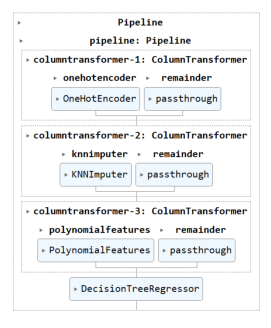

In [60]:
# podoba výsledné pipeline
rdu.show_image('lessons/L08_crossvalidace_tuning/domaci_uloha/img/pipeline.png', 4)

## Vytvoření sítě hyperparametrů

**ÚKOL**

Následující příkaz, tedy `pipe_model.get_params()`, získá seznam všech parametrů, které lze ladit v rámci hledání optimálních hodnot hyperparametrů. Chtěli bychom do sítě prohledávaných hodnot přidat následujících šest hyperparametrů a jejich prohledávaných hodnot.

- onehotencoder || parametr: max_categories || hodnoty [2, 5, 8]
- knnimputer || parametr: n_neighbors || hodnoty [5, 10, 20]
- knnimputer || parametr: weights || hodnoty ['distance', 'uniform']
- polynomialfeatures || parametr: degree || hodnoty [3, 4, 5, 7]
- decisiontreeregressor || parametr: min_samples_split || hodnoty [2, 3, 5]
- decisiontreeregressor || parametr: max_depth || hodnoty [5, 10, 15, None]

**Vyhledejte v dolní části výpisu příkazu `pipe_model.get_params()` přesné názvy těchto šesti hyperparametrů a zkonstuujte objekt `param_grid_dt`.**

Příklad: první řádek v síti hyperparametrů by měl mít tuto podobu: `'pipeline__columntransformer-1__onehotencoder__max_categories': [2, 5, 8]`. Název jsme vyhledali ve výpisu funkce  `pipe_model.get_params()`.

In [61]:
pipe_model.get_params()

{'memory': None,
 'steps': [('pipeline', Pipeline(steps=[('columntransformer-1',
                    ColumnTransformer(remainder='passthrough',
                                      transformers=[('onehotencoder',
                                                     OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                   max_categories=3,
                                                                   sparse_output=False),
                                                     ['cityname', 'state'])],
                                      verbose_feature_names_out=False)),
                   ('columntransformer-2',
                    ColumnTransformer(remainder='passthrough',
                                      transformers=[('knnimputer',
                                                     KNNImputer(add_indicator=True),
                                                     ['bathrooms', 'bedrooms',
                   

In [62]:
param_grid_dt = {
    'pipeline__columntransformer-1__onehotencoder__max_categories': [2, 5, 8],
    'pipeline__columntransformer-2__knnimputer__n_neighbors': [5, 10, 20],
    'pipeline__columntransformer-2__knnimputer__weights':['distance', 'uniform'],
    'pipeline__columntransformer-3__polynomialfeatures__degree':[3, 4, 5, 7],
    'DecisionTreeRegressor__min_samples_split': [2, 3, 5],
    'DecisionTreeRegressor__max_depth':[5, 10, 15, None]
}

In [63]:
cv=5  # počet CV foldů
n_iter=40  # počet prohledaných kombinací hyperparametrů

In [64]:
# objekt RandomizedSearchCV
search = RandomizedSearchCV(estimator=pipe_model, param_distributions=param_grid_dt, n_iter=n_iter, scoring='r2',
                               cv=cv, random_state=42, n_jobs=-1, verbose=3)

## Nácvik a vyhodnocení modelu

In [65]:
# nácvik modelu
search.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('pipeline',
                                              Pipeline(steps=[('columntransformer-1',
                                                               ColumnTransformer(remainder='passthrough',
                                                                                 transformers=[('onehotencoder',
                                                                                                OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                                                              max_categories=3,
                                                                                                              sparse_output=False),
                                                                                                ['cityname',
                                                                                                 'state'])],
                                                                                 verbose_feature_names_out=False)),
                                                              ('columntransformer-2',
                                                               ColumnT...
                                        'DecisionTreeRegressor__min_samples_split': [2,
                                                                                     3,
                                                                                     5],
                                        'pipeline__columntransformer-1__onehotencoder__max_categories': [2,
                                                                                                         5,
                                                                                                         8],
                                        'pipeline__columntransformer-2__knnimputer__n_neighbors': [5,
                                                                                                   10,
                                                                                                   20],
                                        'pipeline__columntransformer-2__knnimputer__weights': ['distance',
                                                                                               'uniform'],
                                        'pipeline__columntransformer-3__polynomialfeatures__degree': [3,
                                                                                                      4,
                                                                                                      5,
                                                                                                      7]},
                   random_state=42, scoring='r2', verbose=3)

In [66]:
# výsledky
print("Best CV Score:", np.round(search.best_score_, 3))
print(f"Train score: {np.round(search.score(X_train, y_train), 3)}")
print(f"Test score: {np.round(search.score(X_test, y_test), 3)}")

Best CV Score: 0.598
Train score: 0.846
Test score: 0.574


In [67]:
# výsledky
print("Best Parameters:", search.best_params_)

Best Parameters: {'pipeline__columntransformer-3__polynomialfeatures__degree': 5, 'pipeline__columntransformer-2__knnimputer__weights': 'distance', 'pipeline__columntransformer-2__knnimputer__n_neighbors': 10, 'pipeline__columntransformer-1__onehotencoder__max_categories': 8, 'DecisionTreeRegressor__min_samples_split': 3, 'DecisionTreeRegressor__max_depth': 10}


**ÚKOL**

Prohlédněte si výpis výše. Jaká je nalezená optimální hloubka rozhodovacího stromu?

**ODPOVĚĎ STUDENT**:
'DecisionTreeRegressor__max_depth': 10. Maximalni optimalni hloubka rozhodovaciho stromu je 10.